# Lab 3 - Regularization and model selection

We have seen that a model which is either too simple or too complex is a poor choice, in the sense that it leads to low prediction accuracy (or conversely, high prediction error).

A way to control the complexity of a model is to minimize a functional which has the following form:

$$
H[f] = L(\mathbf{y}, f(X)) + \alpha V(f)
$$

where $L$ is the _loss_ term, which reflects the adherence to the training data (i.e., how well we're able to predict the outputs relative to the inputs of training points), while V is the _regularization_ term, which increases with the complexity of function $f$.
$\alpha > 0$ is a parameter that controls the amount of regularization.

However, at this point we apparently just moved the problem from "which is the best degree of a polynomial?" to "which is the most appropriate value for the $\alpha$ parameter?".

We need to have a well-defined procedure for selecting the best (given the available data) model, which in this instance of the problem translates to selecting the best value for the $\alpha$ parameter.

<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Warning**: from now on we will abandon "home made" functions wherever possible and start using those provided by the `scikit-learn` python library.

Main concepts:

 * Regularization
 * Regularized Least Squares
 * Model selection
 * K-fold cross validation
 * The `scikit-learn` library
 
The main question we're going to answer: **how to control/choose the complexity of our model?**

## Imports and setup

The usual stuff:

 * Magic command `%matplotlib inline` so that plots are displayed correctly in the notebook.
 * `matplotlib` followed by `seaborn` in order to have fancy plots
 * `numpy` _et similia_ for number crunching.
 
Additional libraries will be imported whenever they are needed

In [43]:
%matplotlib inline

import matplotlib
from matplotlib import pyplot as plt

import seaborn

import numpy as np

## Previously defined functions

To speed up things, here are all functions used in previous labs. We do not need the `my_fit` function as we will use one provided by `scikit-learn`.

<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Warning**: this time the feature mapping function `Phi` is slightly different: this time we do not need to explicitly add a column of ones at the beginning of the matrix as the intercept is automatically handled by the sklearn functions we will use.

In [44]:
def my_generate_ds(n, f, sigma=0.3):
    """
    Function used to generate synthetic data
    """
    
    X = np.random.uniform(-1, 1, size=(n,1))
    y = f(X)
    
    return X, y

# Define the feature mapping
def Phi(X, degree=3):
    """
    Expand an n x 1 matrix into and n x (d-1) matrix,
    where in each column j there is X_i^(j+1)
    """
    
    n, d = X.shape
    
    l = [ X]
    
    for j in range(2, degree+1):
        l.append(X**j)
    
    X_new = np.hstack(tuple(l))
    
    return X_new

## Dataset generation

We generate the same dataset as before, 8 data points from a polynomial of degree 2.

In [45]:
### Dataset generation

n = 8 # the number of samples

w1 = 1.3
w2 = -1.5
c = -0.7

sigma = 0.3

np.random.seed(6)

f = lambda x : w1*x + w2*x**2 + c + np.random.normal(0, sigma**2, size=(n,1))

X, y = my_generate_ds(n, f)

### The `scikit-learn` library

First of all, let's try to reproduce the same results we obtained earlier by computing the results "manually", that is explicitly minimizing the functional.

We still need to expand the matrix using the feature mapping function `Phi`, although as previously stated this time we don't need to explicitly account for the intercept, as the `sklearn` function will do it for us.

Each learning algorithm has its own class; the one for Ordinary Least Squares is `LinearRegression` from `sklearn.linear_model`. 

All those classes follow common conventions:

```python
from sklearn.linear_model import LinearRegression

### Instantiate the object
reg = LinearRegression()

### Fit the regressor on training data (both inputs X and outputs y are required)
reg.fit(X_train,y_train)

### Predict the outputs relative to test data using the fitted model
y_pred = reg.predict()

### For the LinearRegression algorithm, the coefficients are stored in reg.coef_
### The intercept is stored separately in reg.intercept_
w = reg.coef_
c = reg.intercept_
```

<img style="float: left;" src="warning.png" width="20px"> &nbsp; **Warning**: because of _reasons_, you have to add `.ravel()` when copying the coefficients computed by the fit, so that later on there are no issues with the shape of the numpy array of the coefficients. So, from **`w = reg.coef_`** to **`w = reg.coef_.ravel()`**, all the times.

If you have any doubts, check the documentation at http://scikit-learn.org/stable/modules/linear_model.html.

In the box below, try to fit the four curves (try one at a time and plot it) using `LinearRegression`. Use all 8 data points as training set. I left (commented) the code to produce the plots, to speed up things.

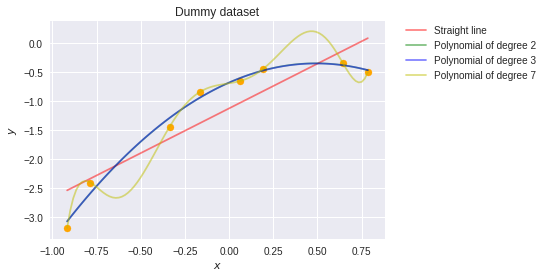

In [46]:
from sklearn.linear_model import LinearRegression

### BEGIN STUDENTS ###

# w_hat1 = ...
# c1 = ...
# ...
# w_hat7 = ...
# c7 = ...

### END STUDENTS ###

fig, ax = plt.subplots()

ax.set_title("Dummy dataset")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.scatter(X, y, c=["orange"]);

# Generate points on the fitted curve
xmin = X.min()
xmax = X.max()

n_ticks = 100

ticks = np.linspace(xmin, xmax, 100).reshape((n_ticks, 1))

# Something has changed here...
y_ticks1 = ticks.dot(w_hat1) + c1
y_ticks2 = Phi(ticks, 2).dot(w_hat2) + c2
y_ticks3 = Phi(ticks, 3).dot(w_hat3) + c3
y_ticks7 = Phi(ticks, 7).dot(w_hat7) + c7

# Plot the fitted curves
curve1 = ax.plot(ticks, y_ticks1, 'r-', label="Straight line", alpha=0.5);
curve2 = ax.plot(ticks, y_ticks2, 'g-', label="Polynomial of degree 2", alpha=0.5);
curve3 = ax.plot(ticks, y_ticks3, 'b-', label="Polynomial of degree 3", alpha=0.5);
curve7 = ax.plot(ticks, y_ticks7, 'y-', label="Polynomial of degree 7", alpha=0.5);

ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);


### In case you want to be extra-sure, grab the code used to compute the w_hat for the 
### polynomial of degree 2 in the previous lab and compare the results using the two procedures
### However, if you do so, you will need to include again the column of 'ones' manually 
### (check the documentation for np.hstack)

## Regularization

A way to extend the simple (Ordinary) Least Squares method in order to have a way to control the complexity of the model is to add a _penalty_ to the minimized functional.
Intuitively, in a linear model, the complexity of the model is related to the absolute value of the coefficients, which control the _smoothness_ of the curve.

A natural candidate for this penalty function would be the _squared $\ell_2$ norm_, that is the euclidean norm. This extension to OLS is called _Regularized Least Squares_ (RLS) or _Ridge Regression_, and the functional minimized has the following form:

$$
\frac{1}{n} \| \mathbf{y} - X \mathbf{w}\|_2^2 + \alpha \| \mathbf{w}\|_2^2
$$

The loss term $\alpha \| \mathbf{w}\|_2^2$ limits the coefficients of $\mathbf{w}$. The $\alpha$ parameter determines the importance of the loss term in the functional: high values of $\alpha$ will lead to vey smooth curves, as most coefficients will shrink, on the other hand small values of $\alpha$ will have almost no effect and the solution returned will be the same which would have been returned by the OLS algorithm.

The truth, as they say, lies in between. Probably.

In order to use the Ridge Regression algorithm you need to instantiate the appropriate `sklearn` class. 

Then, `fit` and `predict` methods are used to fit a model and predict the outputs of any input data (duh!).

```python
from sklearn.linear_models import Ridge

### Choose a value for the regularization parameter
my_alpha = 1

### Instantiate the object for regression
reg = Ridge(alpha=my_alpha)

### Fit the model on training data
reg.fit(X_train, y_train)

### Predict the outputs relative to test data using the fitted model
y_pred = reg.predict()

### For the LinearRegression algorithm, the coefficients are stored in reg.coef_
### The intercept is stored separately in reg.intercept_
w = reg.coef_
c = reg.intercept_
```

As you can see, the steps _after_ the object has been instantiated are exactly the same. This holds for **all** learning algorithms included in the `scikit-learn` library.

In the cell below, fit a polynomial of degree 7 on the dataset using Ridge Regression. Play with the $\alpha$ parameter as will.

<img style="float: left;" src="info.png" width="20px"> &nbsp; **Tip**: choose $0 < \alpha < 100$.

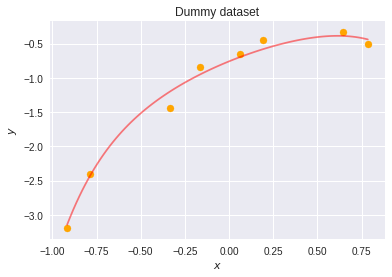

In [47]:
from sklearn.linear_model import Ridge

### BEGIN STUDENTS ###

# j = ...
# my_alpha = ...
# reg = ... 

### END STUDENTS ###

### PLOTTING
fig, ax = plt.subplots()

ax.set_title("Dummy dataset")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.scatter(X, y, c=["orange"]);

# Generate points on the fitted curve
xmin = X.min()
xmax = X.max()

n_ticks = 100

ticks = np.linspace(xmin, xmax, 100).reshape((n_ticks, 1))

# Something has changed here...
y_ticks = reg.predict(Phi(ticks, j))


# Plot the fitted curves
curve1 = ax.plot(ticks, y_ticks, 'r-', label="Straight line", alpha=0.5);

Now try and see what happens with very high or very low values for $\alpha$.

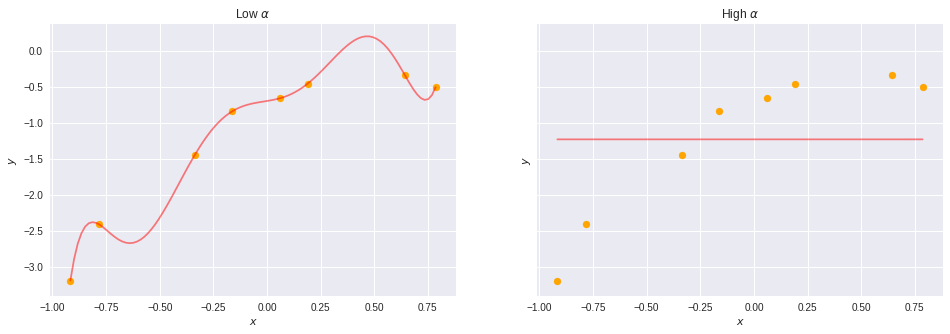

In [48]:
### BEGIN STUDENTS ###

# j = ...
# alpha_low = ...
# alpha_high = ...

# reg_low = ...
# reg_high = ...

### END STUDENTS ###

### PLOTTING

# Generate points on the fitted curve
xmin = X.min()
xmax = X.max()

n_ticks = 100
ticks = np.linspace(xmin, xmax, 100).reshape((n_ticks, 1))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5), sharey=True)

ax1.set_title(r"Low $\alpha$")
ax1.set_xlabel("$x$")
ax1.set_ylabel("$y$")

ax1.scatter(X, y, c=["orange"]);


ax2.set_title(r"High $\alpha$")
ax2.set_xlabel("$x$")
ax2.set_ylabel("$y$")

ax2.scatter(X, y, c=["orange"]);

# Compute the y coordinates of the points of the curves
y_ticks_low = reg_low.predict(Phi(ticks, j))
y_ticks_high = reg_high.predict(Phi(ticks, j))

# Plot the fitted curves
curve1 = ax1.plot(ticks, y_ticks_low, 'r-', label="Straight line", alpha=0.5);
curve2 = ax2.plot(ticks, y_ticks_high, 'r-', label="Straight line", alpha=0.5);

Did you expect this result (the one on the right, especially)?

The reason why you're getting a straight line is that the weight $\alpha$ assigned to the penalty term is so high that the functional is minimized by putting all coefficients equal to zero. You are just left with the intercept, which you will find out to be very close to the average of the outputs.

In [49]:
print("Intercept of the fitted curve:\t{}".format(reg_high.intercept_))
print("Mean of the output values y:\t{}".format(y.mean()))

Intercept of the fitted curve:	[-1.22869354]
Mean of the output values y:	-1.2287099439


## Model selection

We still have a problem: while we _do_ have a way to control the complexity of the model through regularization, the method we have seen relies on a parameter ($\alpha$) which must be chosen somehow.

The most intuitive thing to do is to try and fit several models, each one of them using a different value for $\alpha$, ranging from very low to very high, and see how they perform. This means splitting the dataset in training and test set, training a model on the training set and evaluating its performance on the test set.
The best value will be the one which will produce the model with the lowest test error.

In the cell below, implement the procedure described above using a polynomial of degree 7, plotting the curve relative to the best value of alpha. While training the various models, save in two lists all _training errors_ (i.e., the error you make when trying to predict the same samples on which you trained the model) and _test errors_ (which you will use to determine the best model).

<img style="float: left;" src="info.png" width="20px"> &nbsp; **Hint**: use `np.logspace` to generate arrays of values in a logarithmic space (useful to explore the range of possible values for $\alpha$, as $\mathbb{R}$ has far too many elements).

In [ ]:
from sklearn.metrics import mean_squared_error

### Dataset generation

n = 15 # the number of samples

w1 = 1.3
w2 = -1.5
c = -0.7

sigma = 0.3

np.random.seed(6)

f = lambda x : w1*x + w2*x**2 + c + np.random.normal(0, sigma**2, size=(n,1))

X, y = my_generate_ds(n, f)

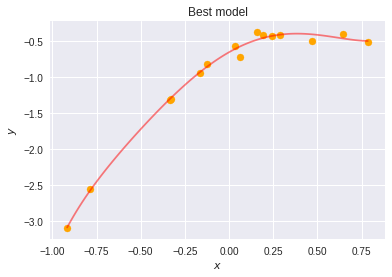

In [70]:
### BEGIN STUDENTS ###

# j = ...
# best_alpha = ...

# train_errors = ...
# test_errors = ...

### END STUDENTS ###

best_alpha = alpha_range[np.argmin(test_errors)]

reg = Ridge(alpha=best_alpha)
reg.fit(Phi(X, j), y)

### PLOTTING
fig, ax = plt.subplots()

ax.set_title("Best model")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.scatter(X, y, c=["orange"]);

# Generate points on the fitted curve
xmin = X.min()
xmax = X.max()

n_ticks = 100

ticks = np.linspace(xmin, xmax, 100).reshape((n_ticks, 1))

# Something has changed here...
y_ticks = reg.predict(Phi(ticks, j))

# Plot the fitted curves
curve1 = ax.plot(ticks, y_ticks, 'r-', label="", alpha=0.5);


Cool, huh?

Let's now plot the training errors and test errors and see how they change with the value of $\alpha$

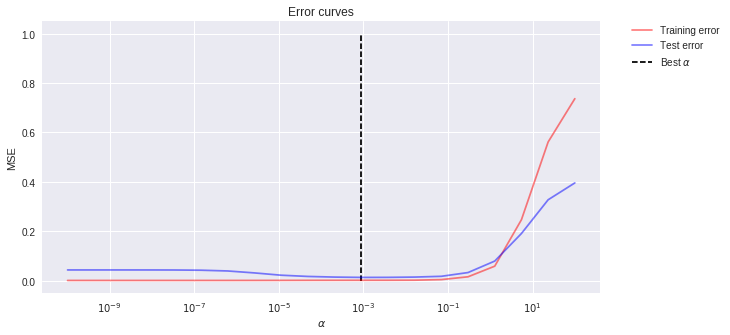

In [79]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title("Error curves")
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("MSE")

# Generate points on the fitted curve
xmin = X.min()
xmax = X.max()

n_ticks = 100

ticks = np.linspace(xmin, xmax, 100).reshape((n_ticks, 1))

# Something has changed here...
y_ticks = reg.predict(Phi(ticks, j))

# Plot the fitted curves
curve2 = ax.semilogx(alpha_range, np.array(train_errors), 'r-', label="Training error", alpha=0.5);
curve1 = ax.semilogx(alpha_range, np.array(test_errors), 'b-', label="Test error", alpha=0.5);

ax.vlines(best_alpha, 0,  1, 'k', linestyles='dashed', label=r"Best $\alpha$")


ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

### K-fold Cross Validation (KCV)

The method we used to select the best model has a flaw: the solution depends on how the original dataset is split initially in training and test set.  
While in this case is not really a problem since we are in a very low-dimensional space and just a few samples are enough to ensure that the both the training and the test set well represent the dataset, this might be an issue in real life scenarios, where the number of dimension is much higher and the number of samples is limited.

A way to reduce the effect induced by the random splitting of the dataset in training and test set is to use a strategy called _k-fold Cross Validation_ (KCV).

The dataset is partitioned into $k$ equal sized subsamples. Of the $k$ subsamples, a single subsample is retained as the validation data for testing the model, and the remaining $k - 1$ subsamples are used as training data. The cross-validation process is then repeated $k$ times (the folds), with each of the $k$ subsamples used exactly once as the validation data. The $k$ results from the folds can then be averaged to produce a single estimation.  
A scheme of such procedure is shown in the figure below.

![K-fold Cross Validation](k-fold.png "K-fold Cross Validation")

Luckily, `scikit-learn` provides a class to perform KCV with little effort.

```python

from sklearn.model_selection import GridSearchCV

# Choose the number of splits
k = 3

# Choose the search space of the parameter
alpha_range = np.logspace(-10,2, 20)

reg = Ridge() # Note how the alpha parameter is NOT specified here

grid_search = GridSearchCV(
                           reg, # The actual estimator object, instantiated
                           param_grid={'alpha' : alpha_range}, # the range of parameters
                           cv=k) # The number of folds

# The training is performed passing the whole dataset
# The class itself behaves as an estimator and handles the splitting in folds
grid_search.fit(X, y)

# Use the GridSearchCV object itself to predict new outputs
grid_search.predict(X)
```

Try to repeat the model selection procedure on the same dataset and model as before, this time using KCV.

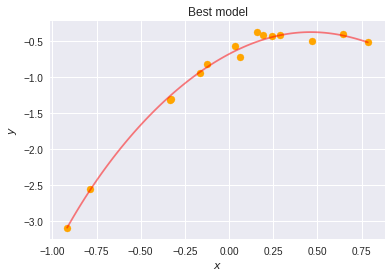

In [84]:
from sklearn.model_selection import GridSearchCV

### BEGIN STUDENTS ###

# j = ...
# k = ...
# alpha_range = ...
# grid_search = ...

### END STUDENTS ###


### PLOTTING
fig, ax = plt.subplots()

ax.set_title("Best model")
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

ax.scatter(X, y, c=["orange"]);

# Generate points on the fitted curve
xmin = X.min()
xmax = X.max()

n_ticks = 100

ticks = np.linspace(xmin, xmax, 100).reshape((n_ticks, 1))

# Something has changed here...
y_ticks = grid_search.predict(Phi(ticks, j))

# Plot the fitted curves
curve1 = ax.plot(ticks, y_ticks, 'r-', label="", alpha=0.5);